In [1]:
%pylab inline
import GPy
import GPyOpt
import numpy as np
import matplotlib.pyplot as plt
from GPyOpt.util.pareto import ParetoFront
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.HvEI import AcquisitionHvEI
from GPyOpt.methods import ModularBayesianMultiobjectiveOptimization

Populating the interactive namespace from numpy and matplotlib


In [2]:
def binhKorn(x,y):
    f1 = 4.*x*x + 4*y*y
    f2 = (x-5.)**2 + (y-5.)**2
    return np.array([f1,f2])

def disc_constraint(x,y):
    return (25.-(x-5)**2-y**2)

def line_constraint(x,y):
    return ((x-8)**2 + (y+3)**2 - 7.7)

In [3]:
np.set_printoptions(precision=6)

objective = None 

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (0.0,5.0)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (0.0,3.0)}]
space = GPyOpt.Design_space(space = space)

kernel   = None 
kernel_c = None

model_f1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_f  = [model_f1,model_f2]

model_c1 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c2 = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)
model_c  = [model_c1,model_c2]

aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

num_init = 23
typ_init = 'latin'
X_init = initial_design(typ_init,space,num_init)

Y_init = np.zeros((X_init.shape[0],2))
C_init = np.zeros((X_init.shape[0],2))

for i in range(num_init):
    Y_init[i,0],Y_init[i,1] = binhKorn(X_init[i,0],X_init[i,1])
    C_init[i,0] = disc_constraint(X_init[i,0],X_init[i,1])
    C_init[i,1] = line_constraint(X_init[i,0],X_init[i,1])

np.set_printoptions(precision=4)
print(np.hstack((X_init,Y_init,C_init)))

[[ 3.2609e-01  2.9348e+00  3.4877e+01  2.6111e+01 -5.4584e+00  8.6411e+01]
 [ 4.0217e+00  1.5000e+00  7.3698e+01  1.3207e+01  2.1793e+01  2.8377e+01]
 [ 9.7826e-01  1.1087e+00  8.7448e+00  3.1317e+01  7.5964e+00  5.8486e+01]
 [ 1.0870e-01  9.7826e-01  3.8752e+00  4.0099e+01  1.1815e-01  7.0399e+01]
 [ 2.0652e+00  2.4130e+00  4.0352e+01  1.5305e+01  1.0564e+01  5.6823e+01]
 [ 2.9348e+00  4.5652e-01  3.5285e+01  2.4908e+01  2.0526e+01  2.9904e+01]
 [ 1.6304e+00  7.1739e-01  1.2692e+01  2.9695e+01  1.3131e+01  4.6690e+01]
 [ 4.6739e+00  1.3696e+00  9.4885e+01  1.3286e+01  2.3018e+01  2.2456e+01]
 [ 5.4348e-01  5.8696e-01  2.5595e+00  3.9336e+01  4.7949e+00  6.0766e+01]
 [ 1.4130e+00  3.2609e-01  8.4121e+00  3.4712e+01  1.2027e+01  4.6751e+01]
 [ 1.8478e+00  1.2391e+00  1.9800e+01  2.4080e+01  1.3528e+01  4.8119e+01]
 [ 3.1522e+00  1.6304e+00  5.0378e+01  1.4768e+01  1.8927e+01  3.7242e+01]
 [ 2.5000e+00  2.0217e+00  4.1350e+01  1.5120e+01  1.4663e+01  4.7768e+01]
 [ 3.5870e+00  2.2826e+00

In [4]:
iter_count = 150-num_init
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init 

while current_iter < iter_count:
    Pareto = ParetoFront(Y_step)
    
    print(Pareto.shape)
    
    acquisition = AcquisitionHvEI(model_f,space,optimizer=aquisition_optimizer, jitter = 1e-3,
                                  model_c=model_c,jitter_c = np.array([0.0,0.0]),P=Pareto,r=np.array([140,60]))
    
    # --- CHOOSE a collection method
    evaluator = GPyOpt.core.evaluators.Sequential(acquisition)
    
    bo_step = ModularBayesianMultiobjectiveOptimization(model_f, space, objective, acquisition, evaluator, 
                                                        X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                                        model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = binhKorn(x_next[0][0],x_next[0][1])
    c1_next = disc_constraint(x_next[0][0],x_next[0][1])
    c2_next = line_constraint(x_next[0][0],x_next[0][1])
    c_next = np.array([c1_next,c2_next])
    print("Current iteration - ",current_iter," : ",np.array([x_next[0][0],x_next[0][1],y_next[0],y_next[1],c_next[0],c_next[1]]))
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

(14, 2)
Current iteration -  0  :  [  5.    3.  136.    4.   16.   37.3]
(15, 2)
Current iteration -  1  :  [  4.7052   2.997  124.484    4.099   15.9313  39.1191]
(16, 2)
Current iteration -  2  :  [  4.8375   2.9881 129.323    4.074   16.0447  38.1588]
(17, 2)
Current iteration -  3  :  [  4.7805   2.9923 127.2299   4.0788  15.9977  38.5733]
(18, 2)
Current iteration -  4  :  [  4.8489   2.9892 129.7866   4.0663  16.042   38.0998]
(19, 2)
Current iteration -  5  :  [  4.8386   2.9889 129.3844   4.0704  16.0402  38.1617]
(20, 2)
Current iteration -  6  :  [  4.9815   2.9511 134.0968   4.1985  16.2909  36.8265]
(20, 2)
Current iteration -  7  :  [  4.897    2.9589 130.9407   4.1768  16.2345  37.437 ]
(20, 2)
Current iteration -  8  :  [  4.796    2.9639 127.1436   4.1875  16.1739  38.1335]
(20, 2)
Current iteration -  9  :  [  4.7579   2.9543 125.4647   4.2433  16.2133  38.2651]
(20, 2)
Current iteration -  10  :  [  4.9514   2.9847 133.6981   4.0639  16.0894  37.4103]
(21, 2)
Current 

KeyboardInterrupt: 

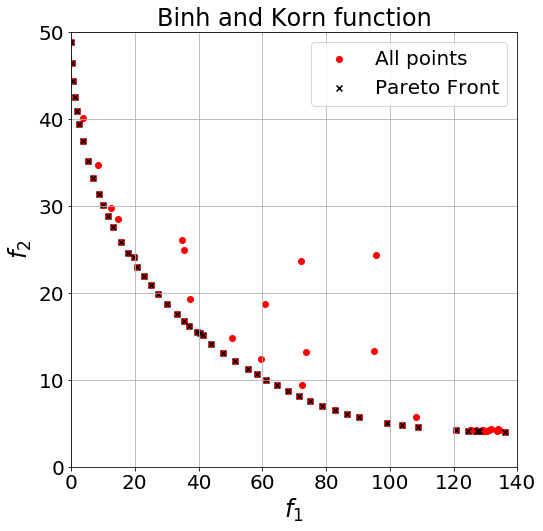

In [5]:
import matplotlib.pyplot as plt

C_clip = np.copy(C_step)
C_clip[C_clip > 0] = 0.0
C_clip = np.sum(C_clip**2,axis=1)

Pareto = ParetoFront(Y_step[C_clip==0.0,:])

fig = plt.figure(figsize=(8,8))
plt.scatter(Y_step[:,0],Y_step[:,1],c='r',label='All points')
plt.scatter(Pareto[:,0],Pareto[:,1],c='k',marker='x',label='Pareto Front')
plt.legend(loc='upper right',fontsize=20)
plt.xlim((   0,140))
plt.ylim((   0, 50))

plt.grid()

plt.title("Binh and Korn function",fontsize=24)
plt.xlabel(r'$f_1$',fontsize=24)
plt.ylabel(r'$f_2$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig("Bihn-Korn.png",bbox_inches='tight')
plt.show()

In [6]:
np.savez('Bihn-Korn.npz',X_step=X_step,Y_step=Y_step,C_step=C_step)